In [1]:
%%capture
!pip install catboost
!pip install optuna
!pip install shap
!pip install -q transformers

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np

from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import StandardScaler


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/My Drive/listings_clean_new.csv')
df['host_identity_verified'] = df['host_identity_verified'].apply(lambda x: 1 if x == 't' else 0)
df['has_availability'] = df['has_availability'].apply(lambda x: 1 if x == 't' else 0)

# reviews = pd.read_csv('/content/drive/My Drive/reviews.csv')

In [23]:
# Train-test split
X = df.drop(columns=['target']).astype(np.float32)#.iloc[:, :420]
y = 1 - df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Model training

In [24]:
model = CatBoostClassifier(early_stopping_rounds=100,
                           depth=4,
                           learning_rate=1,
                           eval_metric='F1:use_weights=False',
                           verbose=True,
                           auto_class_weights='Balanced')
# train the model
model.fit(X_train, y_train, eval_set=(X_test, y_test))
# make the prediction using the resulting model
preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)
print("class = ", preds_class)
print("proba = ", preds_proba)

0:	learn: 0.2906968	test: 0.2967705	best: 0.2967705 (0)	total: 545ms	remaining: 9m 4s
1:	learn: 0.3034631	test: 0.3133954	best: 0.3133954 (1)	total: 999ms	remaining: 8m 18s
2:	learn: 0.3297327	test: 0.3398537	best: 0.3398537 (2)	total: 1.46s	remaining: 8m 5s
3:	learn: 0.3584149	test: 0.3654071	best: 0.3654071 (3)	total: 1.92s	remaining: 7m 57s
4:	learn: 0.3580153	test: 0.3658677	best: 0.3658677 (4)	total: 2.37s	remaining: 7m 52s
5:	learn: 0.3601827	test: 0.3687888	best: 0.3687888 (5)	total: 2.87s	remaining: 7m 55s
6:	learn: 0.3649078	test: 0.3710815	best: 0.3710815 (6)	total: 3.25s	remaining: 7m 41s
7:	learn: 0.3674932	test: 0.3712270	best: 0.3712270 (7)	total: 3.67s	remaining: 7m 35s
8:	learn: 0.3721462	test: 0.3765408	best: 0.3765408 (8)	total: 4.24s	remaining: 7m 47s
9:	learn: 0.3726751	test: 0.3777955	best: 0.3777955 (9)	total: 4.62s	remaining: 7m 37s
10:	learn: 0.3747576	test: 0.3813121	best: 0.3813121 (10)	total: 5.12s	remaining: 7m 40s
11:	learn: 0.3806409	test: 0.3831699	best: 

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test.to_numpy(), np.int32(preds_proba[:, 1] > 0.4)))

              precision    recall  f1-score   support

           0       0.96      0.76      0.85      9601
           1       0.26      0.72      0.38      1136

    accuracy                           0.75     10737
   macro avg       0.61      0.74      0.61     10737
weighted avg       0.88      0.75      0.80     10737



Try to reduce the dimensionality of text embeddings using PCA and see how that affects the model.

In [26]:
text_encoded_features_offset = 420

In [27]:
main_features_train = X_train.iloc[:, :text_encoded_features_offset]
main_features_test = X_test.iloc[:, :text_encoded_features_offset]

In [28]:
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


train_features = []
test_features = []
lengths = []
for i in tqdm(range(5)):
    # Preprocessing for train and fit PCA
    features_train = X_train.iloc[:, text_encoded_features_offset + 384 * i: text_encoded_features_offset + 384 * (i + 1)]
    features_train_norm = features_train - features_train.mean(axis=0)
    pca = PCA(n_components=0.90)
    pca.fit(features_train_norm)
    features = pca.transform(features_train_norm)
    train_features.append(features)
    lengths.append(features.shape[1])
    # For test
    features_test = X_test.iloc[:, text_encoded_features_offset + 384 * i: text_encoded_features_offset + 384 * (i + 1)]
    features_test_norm = features_test - features_train.mean(axis=0)
    features = pca.transform(features_test_norm)
    test_features.append(features)


  0%|          | 0/5 [00:00<?, ?it/s]

In [29]:
sum(lengths)

487

In [30]:
X_train_pca = np.hstack([main_features_train.to_numpy()] + train_features).astype(np.float32)
X_test_pca = np.hstack([main_features_test.to_numpy()] + test_features).astype(np.float32)

It turns out that lower dimensionality of text embeddings does not change the performance of the model at all. Then maybe they don't matter after all?

In [31]:
model = CatBoostClassifier(early_stopping_rounds=100,
                           depth=4,
                           learning_rate=1,
                           eval_metric='F1:use_weights=False',
                           verbose=True,
                           auto_class_weights='Balanced')
# train the model
model.fit(X_train_pca, y_train, eval_set=(X_test_pca, y_test))
# make the prediction using the resulting model
preds_class = model.predict(X_test_pca)
preds_proba = model.predict_proba(X_test_pca)
print("class = ", preds_class)
print("proba = ", preds_proba)

0:	learn: 0.3108024	test: 0.3191888	best: 0.3191888 (0)	total: 142ms	remaining: 2m 21s
1:	learn: 0.3262064	test: 0.3324260	best: 0.3324260 (1)	total: 305ms	remaining: 2m 32s
2:	learn: 0.3470023	test: 0.3530752	best: 0.3530752 (2)	total: 440ms	remaining: 2m 26s
3:	learn: 0.3622542	test: 0.3678930	best: 0.3678930 (3)	total: 578ms	remaining: 2m 24s
4:	learn: 0.3745558	test: 0.3754379	best: 0.3754379 (4)	total: 795ms	remaining: 2m 38s
5:	learn: 0.3787926	test: 0.3757751	best: 0.3757751 (5)	total: 931ms	remaining: 2m 34s
6:	learn: 0.3814094	test: 0.3800041	best: 0.3800041 (6)	total: 1.11s	remaining: 2m 37s
7:	learn: 0.3837476	test: 0.3854057	best: 0.3854057 (7)	total: 1.23s	remaining: 2m 33s
8:	learn: 0.3856144	test: 0.3891823	best: 0.3891823 (8)	total: 1.44s	remaining: 2m 39s
9:	learn: 0.3882291	test: 0.3908533	best: 0.3908533 (9)	total: 1.66s	remaining: 2m 44s
10:	learn: 0.3897425	test: 0.3896325	best: 0.3908533 (9)	total: 1.85s	remaining: 2m 46s
11:	learn: 0.3930932	test: 0.3921233	best:

Yes, completely removing text embeddings columns does not affect the performance of the model at all. It seems that descriptions and names have no connection to whether a listing will be classified as 'low-rated' or 'high-rated'.

These are actually good news because these columns have occupied a lot of space and now I can through them out, reduce memory requirements and speed up calculations.

In [115]:
# Train-test split
X = df.drop(columns=['target']).iloc[:, :420]
X = X.drop(columns=X.filter(regex='availability').columns)
y = 1 - df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [133]:
model = CatBoostClassifier(early_stopping_rounds=100,
                           depth=4,
                           learning_rate=1,
                           eval_metric='F1:use_weights=False',
                           verbose=True,
                           auto_class_weights='Balanced')
# train the model
model.fit(X_train, y_train, eval_set=(X_test, y_test))
# make the prediction using the resulting model
preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)
print("class = ", preds_class)
print("proba = ", preds_proba)

0:	learn: 0.3314872	test: 0.3376258	best: 0.3376258 (0)	total: 56.8ms	remaining: 56.8s
1:	learn: 0.3366765	test: 0.3423070	best: 0.3423070 (1)	total: 132ms	remaining: 1m 5s
2:	learn: 0.3544075	test: 0.3646789	best: 0.3646789 (2)	total: 204ms	remaining: 1m 7s
3:	learn: 0.3627364	test: 0.3672575	best: 0.3672575 (3)	total: 297ms	remaining: 1m 13s
4:	learn: 0.3663475	test: 0.3710843	best: 0.3710843 (4)	total: 383ms	remaining: 1m 16s
5:	learn: 0.3671794	test: 0.3692063	best: 0.3710843 (4)	total: 470ms	remaining: 1m 17s
6:	learn: 0.3737884	test: 0.3734036	best: 0.3734036 (6)	total: 544ms	remaining: 1m 17s
7:	learn: 0.3797027	test: 0.3767700	best: 0.3767700 (7)	total: 625ms	remaining: 1m 17s
8:	learn: 0.3805722	test: 0.3776052	best: 0.3776052 (8)	total: 718ms	remaining: 1m 19s
9:	learn: 0.3835786	test: 0.3800289	best: 0.3800289 (9)	total: 801ms	remaining: 1m 19s
10:	learn: 0.3845518	test: 0.3804999	best: 0.3804999 (10)	total: 872ms	remaining: 1m 18s
11:	learn: 0.3860723	test: 0.3823894	best: 

Here are the most important features for the model.

In [117]:
sorted(list(zip(X_test.columns, model.get_feature_importance())), key=lambda x: -x[1])[:20]

[('number_of_reviews', 40.99006781906649),
 ('latitude', 3.763214324822928),
 ('reviews_per_month', 3.661027285855192),
 ('longitude', 3.28298763546697),
 ('price', 3.1373267924508514),
 ('host_is_superhost', 3.0964351909078385),
 ('num_amenities', 1.957211639175431),
 ('host_total_listings_count', 1.616842719005164),
 ('host_acceptance_rate', 1.521370291003442),
 ('calculated_host_listings_count_entire_homes', 1.381263183926542),
 ('number_of_reviews_ltm', 1.370903173907018),
 ('maximum_maximum_nights', 1.199396566248592),
 ('accommodates', 1.0466858465471973),
 ('maximum_nights', 1.0390294836170808),
 ('host_response_rate', 0.9552882512121849),
 ('maximum_minimum_nights', 0.8931250322003548),
 ('cooking basics', 0.7996469760459302),
 ('maximum_nights_avg_ntm', 0.7137464422039912),
 ('host_listings_count', 0.6447062468030004),
 ('host_for_60_months', 0.617533217810976)]

# Hyperparameter Tuning

In [21]:
import optuna
from sklearn.metrics import f1_score, balanced_accuracy_score
from optuna.integration import CatBoostPruningCallback

In [22]:
def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        # "used_ram_limit": "3gb",
        'eval_metric': 'F1'
    }
    if param['objective'] == "Logloss":
        param['auto_class_weights'] = 'Balanced'
        param["eval_metric"] = 'F1'#:use_weights=False'
        pruning_callback = CatBoostPruningCallback(trial, 'F1')#:use_weights=False')
    else:
        pruning_callback = CatBoostPruningCallback(trial, 'F1')

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = CatBoostClassifier(**param)

    gbm.fit(X_train, y_train, 
            eval_set=(X_test, y_test), 
            verbose=0,
            early_stopping_rounds=100,
            callbacks=[pruning_callback])

    # evoke pruning manually.
    pruning_callback.check_pruned()

    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    f1 = f1_score(y_test, pred_labels)

    return f1

study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
study.optimize(objective, n_trials=100, timeout=600)

[I 2023-05-03 01:05:03,710] A new study created in memory with name: no-name-85869b64-85a7-440e-8dac-7aa713d49929
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
[I 2023-05-03 01:05:22,571] Trial 0 finished with value: 0.3529641185647425 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.014659132678421895, 'depth': 10, 'learning_rate': 0.0007874338191351073, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.3529641185647425.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
CatBoostPruningCallback is experimental (supported from v3.0.0

Optuna has found the best set of hyperparameters which I list below.

In [ ]:
best_parameters = {'objective': 'Logloss', 
                   'colsample_bylevel': 0.0994229355648656, 
                   'depth': 6, 
                   'learning_rate': 0.19282266196320139, 
                   'boosting_type': 'Ordered', 
                   'bootstrap_type': 'Bayesian', 
                   'bagging_temperature': 1.4629733968739438,
                   }


Despite of all efforts, the model fails to achieve a high accuracy. If a high-capacity SOTA model such as GBM does not succeed, then no other model will. It means that there is not enough useful information in this dataset, and we cannot reliable determine the quality of the listing by its page.

# Interpretation. SHAP

The performance of the model is far from random guessing, however, so we can try to extract some useful insights from the model. I will use SHAP for that.

In [119]:
# X_test_sample = X_test.sample(n=100)
X_test_sample = X_test[X_test.price < 1000]

In [120]:
import shap

f = lambda x: model.predict_proba(x)[:, 1]
med = np.median(X_train.astype(np.float32), axis=0).reshape((1,X_train.shape[1]))

In [121]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_sample.astype(np.float32))

Let's see how feature values affect model output. 

* 'number_of_reviews' - it seems that low number of reviews may either strongly promote class 0 (high-rated) or class 1 (low-rated). This result is not quite well understood.
* 'reviews_per_month' - low value promotes class 1. This may be more of a consequence than a cause. If a listing has a low rating, then less people will live in it and less people will leave reviews.
* '*_nights' - low values promote both classes 0 and 1, so there is no evidence of this feature's importance.
* '*_price' - low prices are an indicator of 'low-rated' listings. This can also be a consequence. If hosts have bad listings, then the only thing they can attract people with is low cost.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


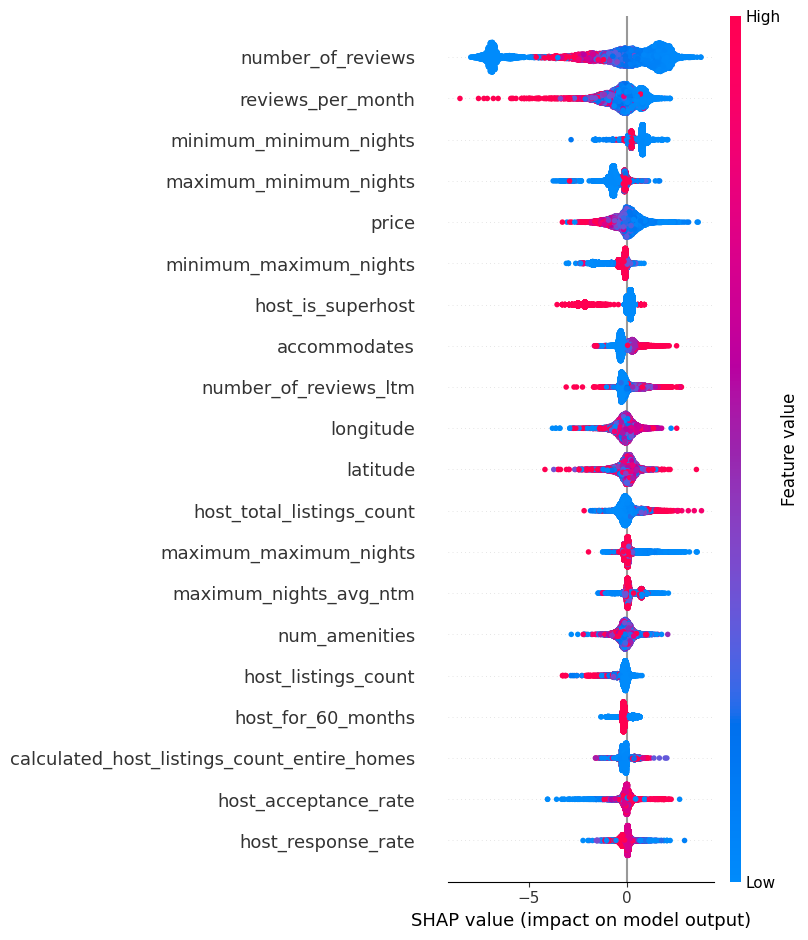

In [122]:
shap.summary_plot(shap_values)

# Feature analysis

Though the model looks at listing's coordinates when making a decision, I cannot see any positional pattern, any grouping of 'low-rated' listings inside some area.

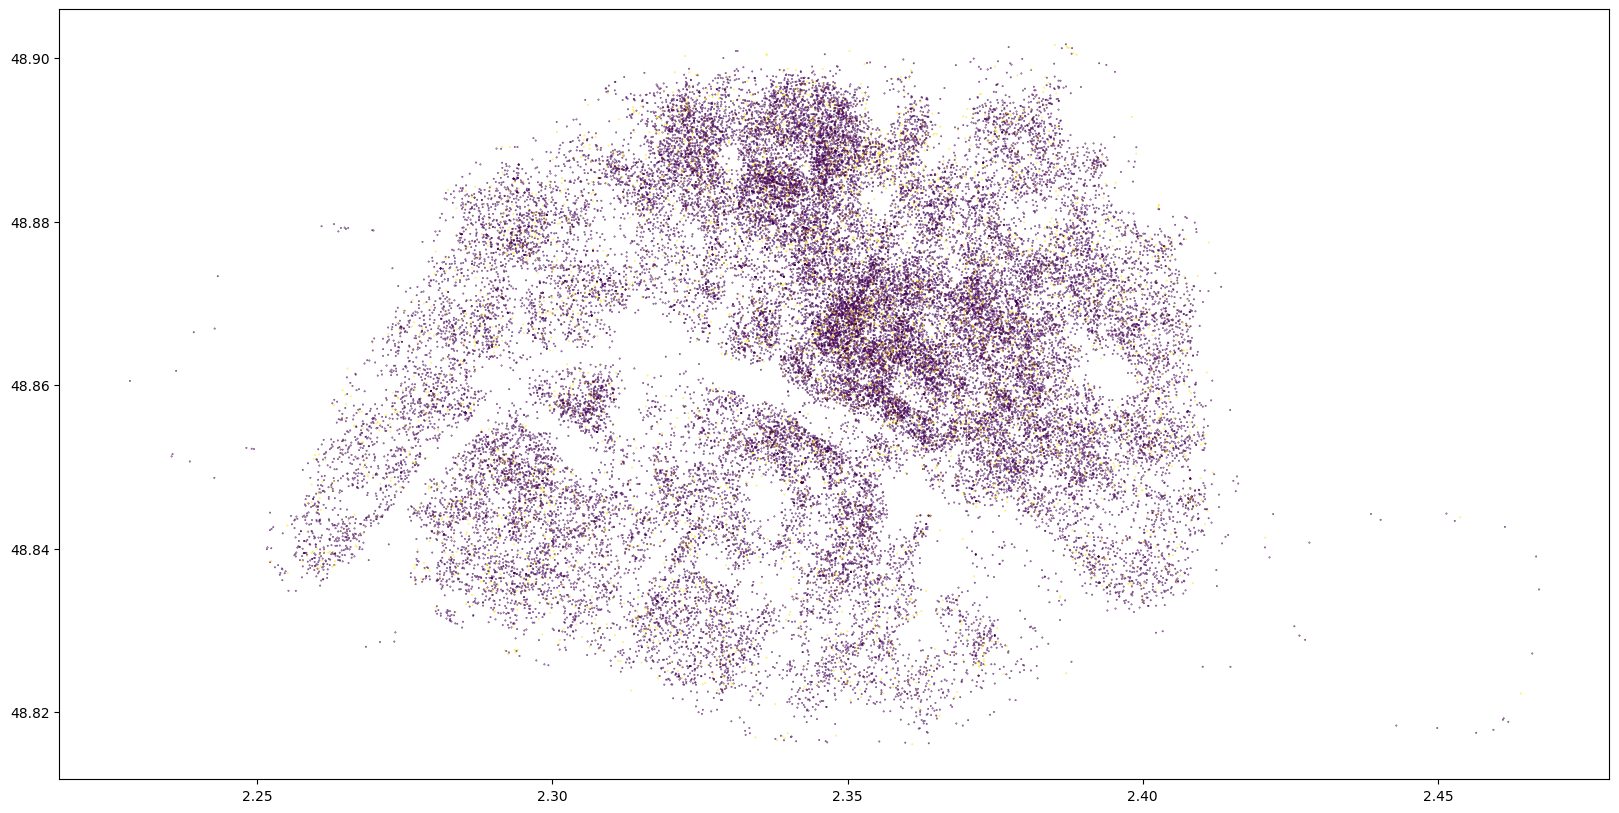

In [54]:
plt.figure(figsize=(20, 10))
plt.scatter(x=X_train.longitude, y=X_train.latitude, c=y_train, s=0.1)
plt.show()

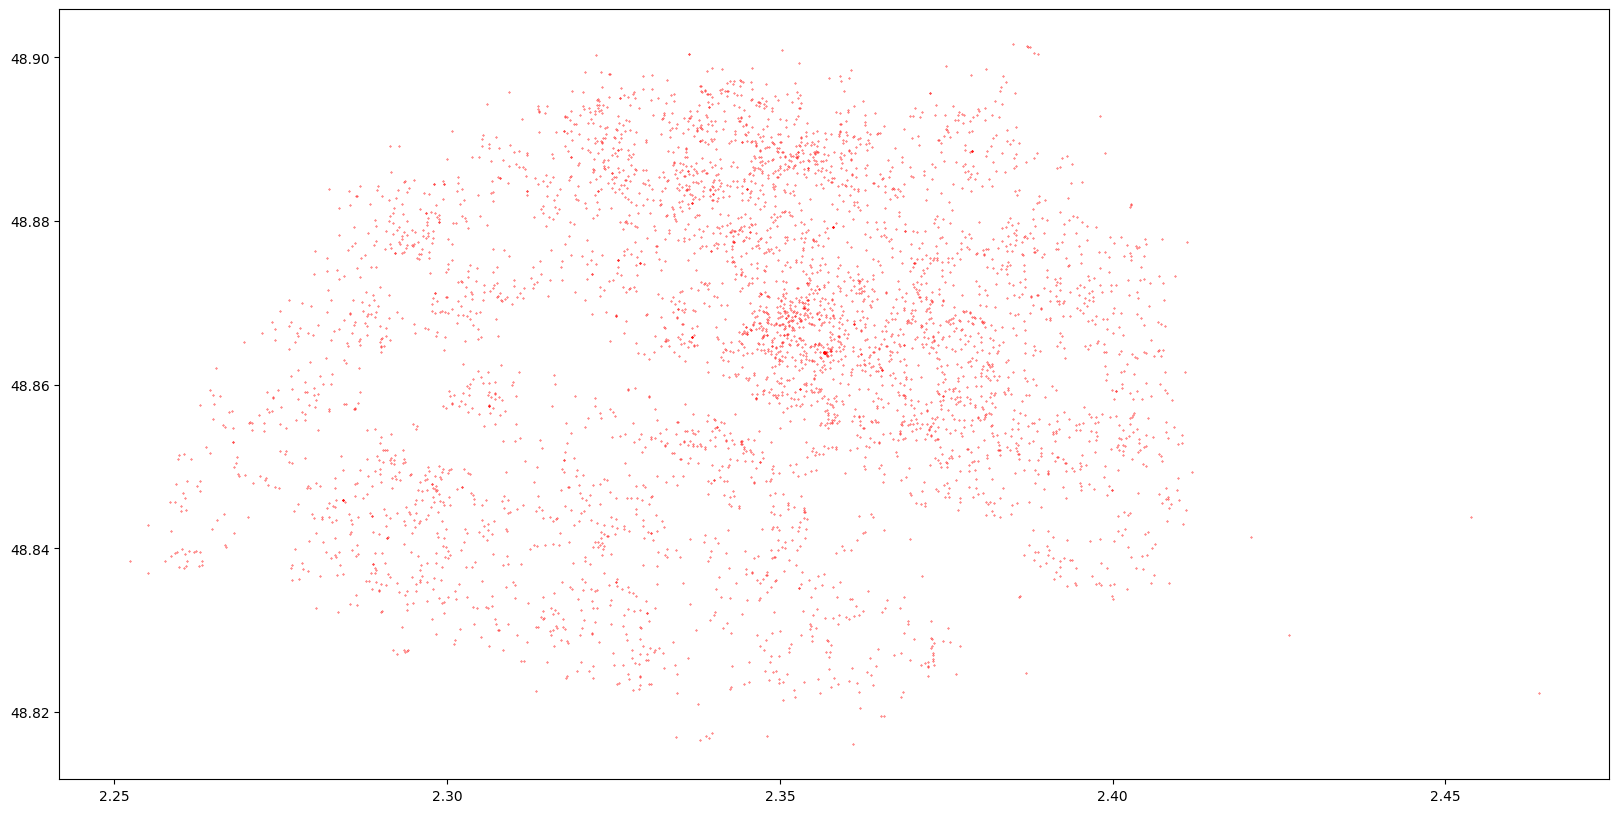

In [49]:
plt.figure(figsize=(20, 10))
plt.scatter(x=X_train.longitude[y_train == 1], y=X_train.latitude[y_train == 1], s=0.1, c='r')
plt.show()

This plot shows that certain combinations of 'number_of_reviews' and 'host_is_superhost' features result in positive contribution to class probability. Namely, if there is a low number of reviews and host is not superhost, then the listing will probably have a low rating.

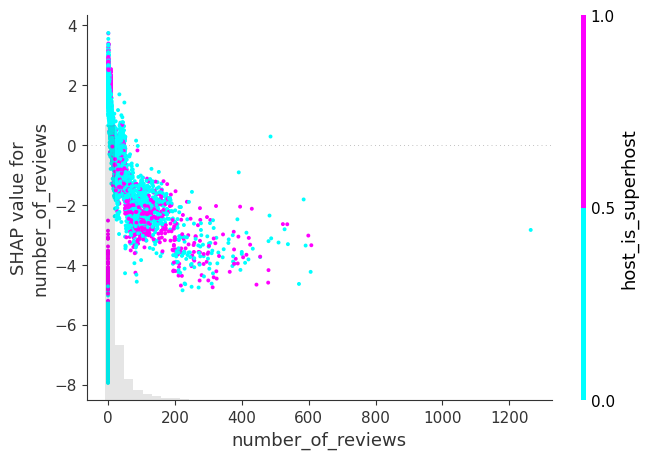

In [78]:
shap.plots.scatter(shap_values[:,"number_of_reviews"], color=shap_values, cmap=plt.get_cmap("cool"), dot_size=8)

Impact of 'price' feature is best visible in conjunction with 'number_of_reviews_ltm' (number of reviews in the last 12 month).

The graph shows that if listing is of low price and has a lot of reviews, then it will probably lead to 'low-rated' classification. In contrast, if a listing has high price and a lot of reviews, then it will lead to 'high-rated classification.

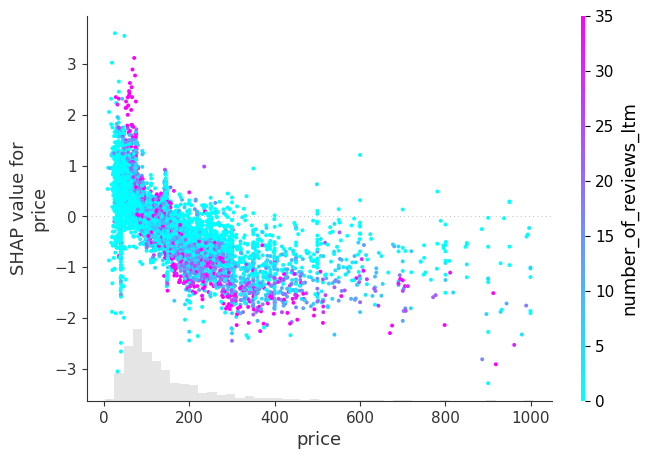

In [85]:
shap.plots.scatter(shap_values[:,"price"], color=shap_values, cmap=plt.get_cmap("cool"), dot_size=8)

Some of the dependencies do not make a lot of sense.

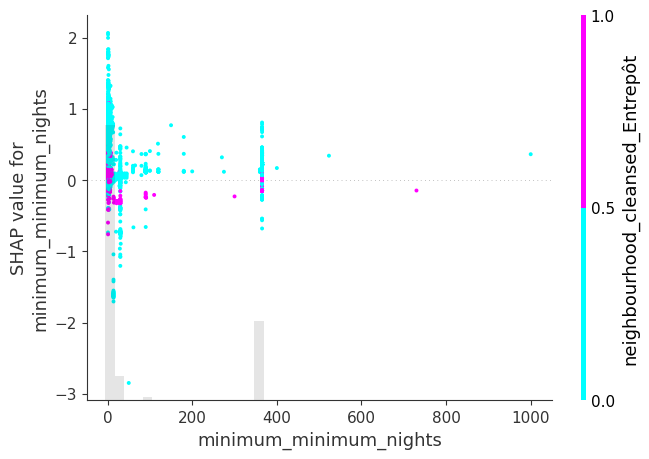

In [93]:
shap.plots.scatter(shap_values[:,"minimum_minimum_nights"], color=shap_values, cmap=plt.get_cmap("cool"), dot_size=8)

On average, a higher number of listed amenities leads to a 'high-rated' prediction.

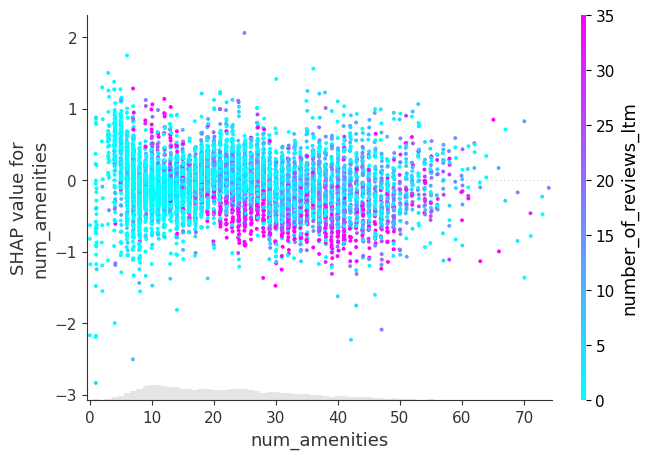

In [87]:
shap.plots.scatter(shap_values[:,"num_amenities"], color=shap_values, cmap=plt.get_cmap("cool"), dot_size=8)

If there is a high review frequency on a listing with large total number of reviews, then it will be a sign of 'high-rated' listing. In contrast, if high review frequency is on a listing with small total number of reviews, then it will be a sign of 'high-rated' listing. That can probably be due to the experience of listing's host. More reviews are on listings which are on the site for a longer time, meaning that their hosts have more experience or just had time to remove all bad traits.

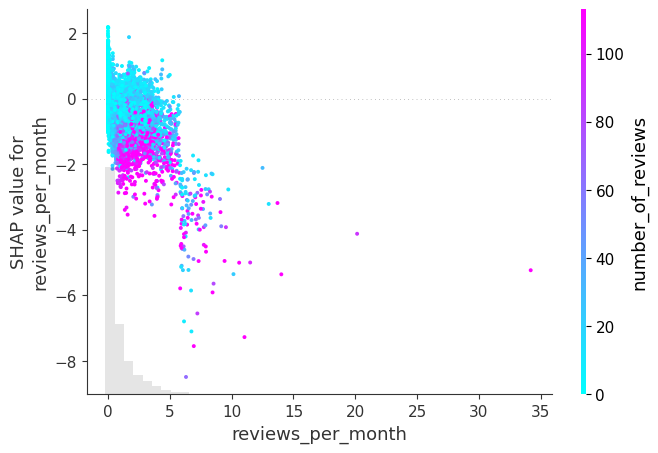

In [94]:
shap.plots.scatter(shap_values[:,"reviews_per_month"], color=shap_values, cmap=plt.get_cmap("cool"), dot_size=8)

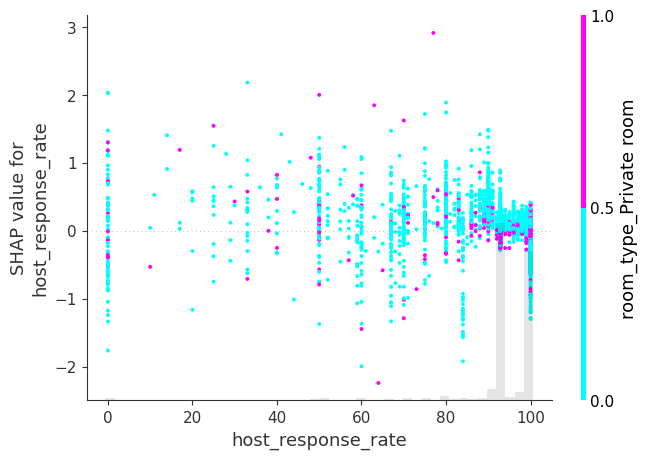

In [123]:
shap.plots.scatter(shap_values[:,"host_response_rate"], color=shap_values, cmap=plt.get_cmap("cool"), dot_size=8)

In [108]:
# Train-test split
X = df.drop(columns=['target', 'reviews_per_month', 'number_of_reviews', 'number_of_reviews_ltm', 'host_is_superhost', 'price']).iloc[:, :420]
X = X.drop(columns=X.filter(regex='availability').columns)
y = 1 - df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [109]:
model = CatBoostClassifier(early_stopping_rounds=100,
                           depth=4,
                           learning_rate=1,
                           eval_metric='F1:use_weights=False',
                           verbose=True,
                           auto_class_weights='Balanced')
# train the model
model.fit(X_train, y_train, eval_set=(X_test, y_test))
# make the prediction using the resulting model
preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)
print("class = ", preds_class)
print("proba = ", preds_proba)

0:	learn: 0.2320166	test: 0.2327609	best: 0.2327609 (0)	total: 38.1ms	remaining: 38.1s
1:	learn: 0.2460773	test: 0.2457450	best: 0.2457450 (1)	total: 68.4ms	remaining: 34.1s
2:	learn: 0.2734412	test: 0.2780977	best: 0.2780977 (2)	total: 97.2ms	remaining: 32.3s
3:	learn: 0.2746251	test: 0.2795431	best: 0.2795431 (3)	total: 145ms	remaining: 36.2s
4:	learn: 0.2784632	test: 0.2821680	best: 0.2821680 (4)	total: 213ms	remaining: 42.5s
5:	learn: 0.2790465	test: 0.2736493	best: 0.2821680 (4)	total: 265ms	remaining: 43.9s
6:	learn: 0.2861785	test: 0.2858861	best: 0.2858861 (6)	total: 343ms	remaining: 48.7s
7:	learn: 0.2877162	test: 0.2864657	best: 0.2864657 (7)	total: 392ms	remaining: 48.6s
8:	learn: 0.2891448	test: 0.2903811	best: 0.2903811 (8)	total: 443ms	remaining: 48.8s
9:	learn: 0.2844391	test: 0.2864078	best: 0.2903811 (8)	total: 492ms	remaining: 48.7s
10:	learn: 0.2848818	test: 0.2888722	best: 0.2903811 (8)	total: 545ms	remaining: 49s
11:	learn: 0.2909918	test: 0.2946804	best: 0.2946804

In [111]:
import shap

X_test_sample = X_test#[X_test.price < 1000]

f = lambda x: model.predict_proba(x)[:, 1]
med = np.median(X_train.astype(np.float32), axis=0).reshape((1,X_train.shape[1]))
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_sample.astype(np.float32))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


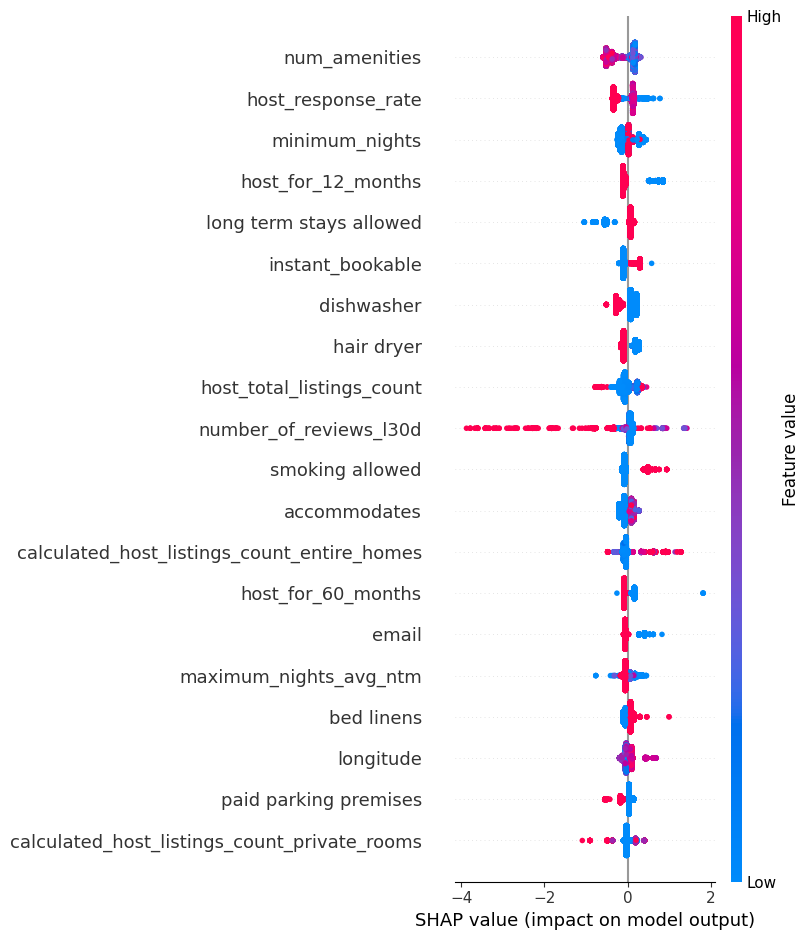

In [112]:
shap.summary_plot(shap_values)

In [113]:
from sklearn.metrics import classification_report

print(classification_report(y_test.to_numpy(), np.int32(preds_proba[:, 1] > 0.4)))

              precision    recall  f1-score   support

           0       0.96      0.49      0.65      9601
           1       0.16      0.82      0.27      1136

    accuracy                           0.52     10737
   macro avg       0.56      0.65      0.46     10737
weighted avg       0.87      0.52      0.61     10737



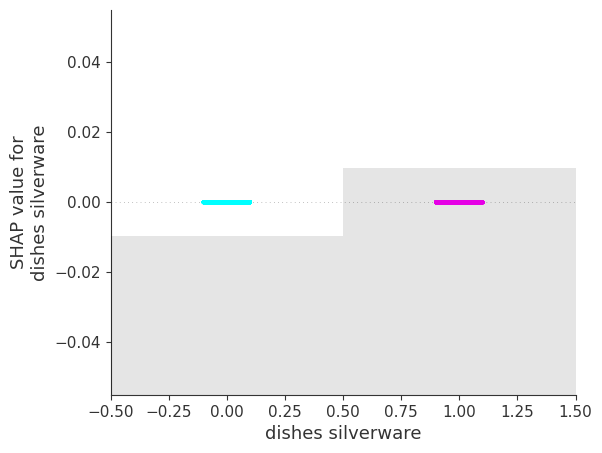

In [114]:
shap.plots.scatter(shap_values[:,"dishes silverware"], color=shap_values, cmap=plt.get_cmap("cool"), dot_size=8)